In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Predicting Diabetes Prognosis

## Introduction:

Diabetes is a medical condition where the afflicted body is unable to create enough insulin and therefore cannot efficiently transform glucose into energy for the body to properly utilize. According to the American Diabetes organization, 11.3 percent of Americans are diagnosed with diabetes. This high percentage puts a strain and pressure on the medical system in terms of treatment and diagnosis of this disease. With such a prevalence in the population, this leads us to our question: is it possible to create a classifier capable of accurately diagnosing diabetes based on the patient’s medical factors? To answer this question, we will be using the Pima Indians Diabetes Dataset. This dataset contains the health information of 768 women from Phoenix, Arizona. Diabetes was the variable that was tested in the dataset, along with multiple other health variables being pregnancies, Glucose tolerance (two hour plasma glucose concentration after 75g anhydrous glucose in mg/dl), blood pressure (Diastolic Blood Pressure in mmHg), skin thickness (Triceps skin fold thickness in mm), insulin (2 h serum insulin in mu U/ml), BMI (Body Mass Index in kg/m2), and age (years). 

## Preliminary exploratory data analysis:

##### Demonstrate that the dataset can be read from the web into R:

In [4]:
diabetes_data = read_csv("diabetes.csv")


Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### Clean and wrangle your data into a tidy format:

In [5]:
diabetes_mutant = diabetes_data |> 
    mutate(Outcome = as_factor(Outcome))
diabetes_mutant

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


##### Using only training data, summarize the data in at least one table (this is exploratory data analysis):
##### Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis):

Outcome,Median Insulin,Mean Insulin
<fct>,<dbl>,<dbl>
0,39,68.7920
1,0,100.3358


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



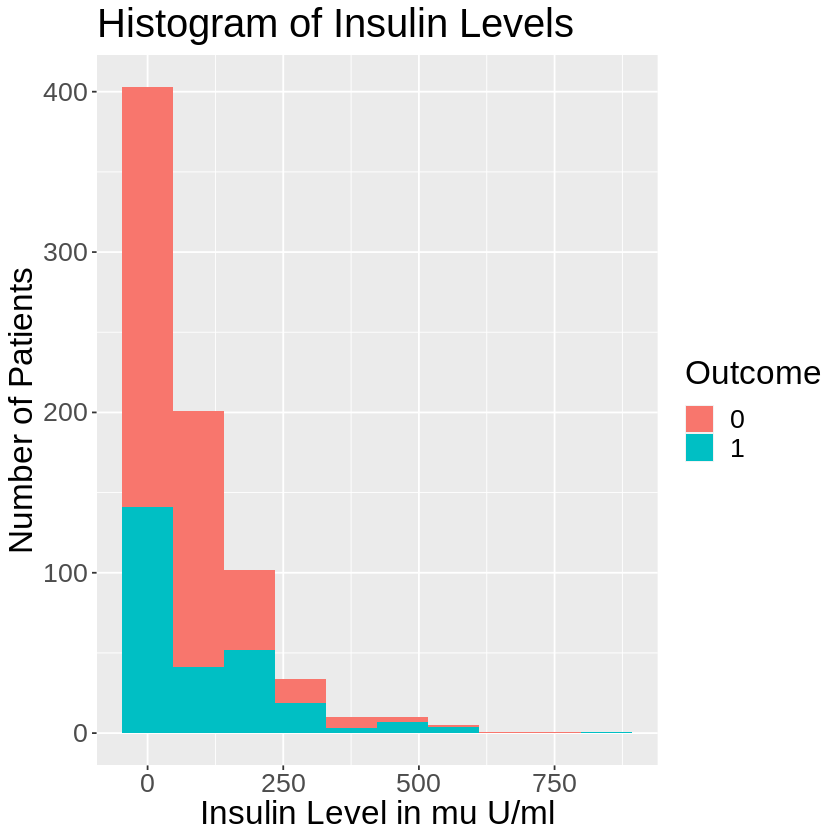

In [6]:
Insulin_summarized <- diabetes_mutant |>
group_by(Outcome) |>
summarize("Median Insulin" = median(Insulin),
         "Mean Insulin" = mean(Insulin))
Insulin_summarized
Insulin_visulized <- diabetes_mutant |>
select(Insulin, Outcome) |>
ggplot(aes(x = Insulin, fill = Outcome)) +
geom_histogram() +
labs(x = "Insulin Level in mu U/ml", y = "Number of Patients", fill = "Outcome", title = "Histogram of Insulin Levels") +
theme(text = element_text(size = 20)) +
stat_bin(bins = 10)
Insulin_visulized


The distibution of insulin levels of those with diabetes seems to be heavily skewed right. In addition, the distribution of insulin levels of those without diabetes seems to be heavily skewed right.

Age Range of Those With Diabetes
<dbl>
21
70


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



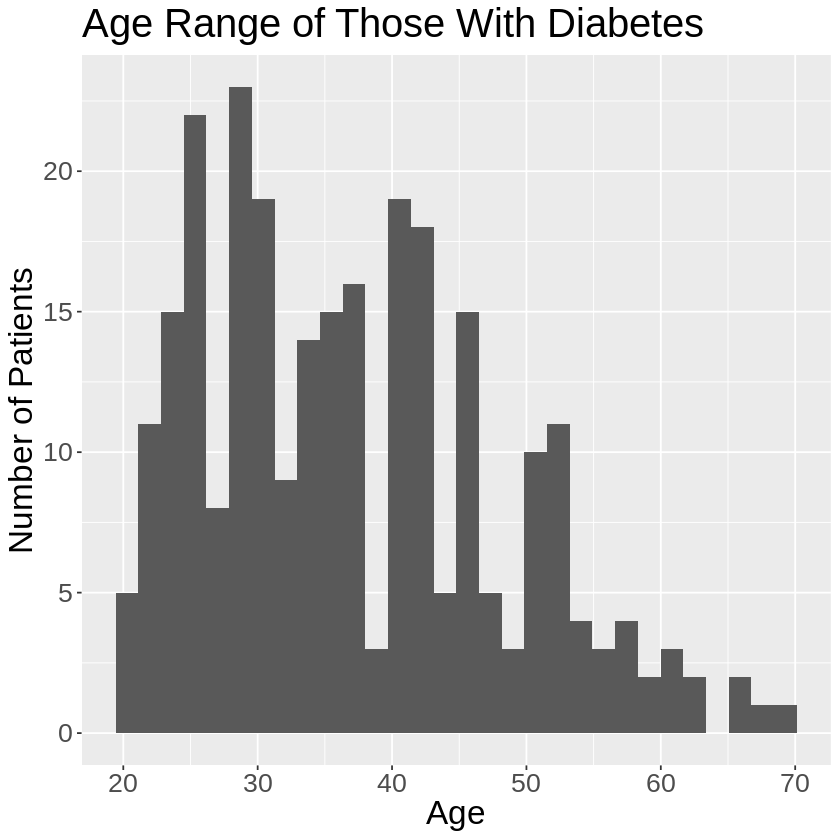

In [7]:
Age_summarized <- diabetes_mutant |>
filter(Outcome == 1) |>
summarize("Age Range of Those With Diabetes" = range(Age))
Age_summarized

Age_visulized <- diabetes_mutant |>
select(Age, Outcome) |>
filter(Outcome == 1) |>
ggplot(aes(x = Age)) +
geom_histogram() +
labs(x = "Age", y = "Number of Patients", title = "Age Range of Those With Diabetes") +
theme(text = element_text(size = 20)) +
stat_bin(bins = 30)
Age_visulized

The fact that there is a wide range of age for those with diabetes makes sense because there are patients with type 1 diabetes, which means they were born with it.

## Methods

##### Explain how you will conduct either your data analysis and which variables/columns you will use: